In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pickle
from scipy.optimize import shgo

import topo_generic as topo
import JHD
import importlib
importlib.reload(topo)
importlib.reload(JHD)

#%matplotlib widget  ## better to use this for interactive plot with jupyter lab
%matplotlib inline

**This figure is similar as figure 5, but for different values of $E_J/E_C$ in the symmetric case.**

# Generate data

One may use this mimization algorithm (same as fig5) to generate data for multiple value of $\alpha$.

It may take several hours for each value of $E_J/E_C$.

In [ ]:
%%time

#use ratio=Ej/Ec, while keeping Ej*Ec constant
alpha=1/pi
Ej=1/(2*np.pi*alpha)
Ec=np.pi*alpha
ratio=Ej/Ec
print(f'Fig_ratio_alpha_2: \n Ratio Ej/Ec={ratio:.4f} for alpha={alpha:.4f}')

N=13

asym=[1,1,1,1,1]

tol=1e-8

phiBlist=np.linspace(0,np.pi,51)
dimphiB=len(phiBlist)

nglist=np.linspace(0,0.5,51)
dimng=len(nglist)
    
deg_gap=np.zeros([dimphiB,dimng])
deg_pos=np.zeros([dimphiB,dimng,4]) #4 coordinates: L, R, ng, phiB
deg_time=np.zeros([dimphiB,dimng])

for (iphiB,phiB) in enumerate(phiBlist):
    print('phiB : ',phiB)
    print('{datetime}'.format(datetime=datetime.datetime.now()))
    param=[N,Ej,Ec,phiB,asym,tol]
    start_time=time.time()
    
    for (ing,ng) in enumerate(nglist):
        start_time_ng=time.time()
        print(ing)
        if ing%10==0:
            print(f'ing is {ing}')
        if ing==0: continue ##skip first iteration to use end of interval to define it
            
        bnds=((0,2*np.pi), (0,2*np.pi), (nglist[ing-1],nglist[ing]))
        
        temp_deg=shgo(cpp_2m.minimize_phiL_phiR_ng,bnds,args=param, \
                      n=101, iters=9, sampling_method='sobol', \
                      minimizer_kwargs={'method':'SLSQP', 'options':{'options':{'ftol':1e-8, 'eps':1e-10, 'maxiter':500}}}, \
                      options={'ftol':1e-8, 'maxtime':600, 'local_iter':10} )


        deg_time[iphiB,ing]=time.time()-start_time
        deg_gap[iphiB,ing]=temp_deg.fun
        deg_pos[iphiB,ing]=np.hstack([temp_deg.x,phiB])
        
        print(f'gap: {deg_gap[iphiB,ing]} \t ng: {deg_pos[iphiB,ing,2]} \t phiB: {deg_pos[iphiB,ing,3]}')
        if ing%10==0:
            print(f'this ng run took {time.time()-start_time_ng:.4f}sec')
        print()
    print(f'{time.time()-start_time}sec for this phiB run')
    print(f'estimate remaining time to {(time.time()-start_time)*(dimphiB-iphiB+1)/60}min')

# Load article data

Loading four files for each quadrant of the figure.

Multiple files are available, with different values of $\alpha$. 

They contain both the minimum gap value, and the exact position of the degeneracies [deg_gap,deg_pos]. 

JHD_fig8_alpha_i.pkl contains :

| i | $\alpha$ | $E_J/E_C$ |
| --- | --- | ---|
| 1 | 0.1 | 5.1|
| 2 | 1/$\pi$ |0.5|
| 3 | 0.75 | 0.09|
| 4 | 2 | 0.0127|
| 5 | 1.5 | 0.0225|
| 6 | 1.25 | 0.0324|
| 9 | 0.25 | 0.811|

Note: JHD_fig8_alpha_1.pkl has some numerical errors, corrected in JHD_fig8_alpha_1_2.pkl. Both are loaded below

In [2]:
deg_gap=np.empty((4,51,51))

name=[1,2,3,5] #which file to load, cf table above

#load each quadrant
for i in range(1,5):
    filename='fig8_data/JHD_fig8_alpha_'+str(name[i-1])+'.pkl'
    with open(filename,'rb') as outfile:
        a,b=pickle.load(outfile)
        print(np.shape(a))
        deg_gap[i-1]=a

##correct alpha_1 to remove some numerical errors
filename='fig8_data/JHD_fig8_alpha_1_2.pkl'
with open(filename,'rb') as outfile:
    a,b=pickle.load(outfile)
    print(np.shape(a))
    deg_gap[0,10:14]=a

(51, 51)
(51, 51)
(51, 51)
(51, 51)
(4, 51)


# display data

**Data are computed only in one quadrant, then the symmetry of the parameter space is used to fill the whole phase space with the function "unfold()".**

In [3]:
def unfold(phiBlist,nglist,deg_gap):
    phiBlist=np.linspace(-np.pi,np.pi,2*len(phiBlist)-1)
    
    #nglist: remove last element, then shift everything by half step (so now elem i corresponds to middle of interval i)
    nglist=np.linspace(0,1,2*len(nglist)-1)[:-1]
    nglist=nglist+0.5*(nglist[1]-nglist[0])
    
    ## remove phiB=pi from second set
    deg_gap=np.concatenate((deg_gap[::-1][1:],deg_gap),0)
    #unfold on ng: remove first ng point, unfold, then remove first elem which is centered at ng=0.5, counted twice
    deg_gap=np.concatenate((deg_gap,deg_gap[:,1:][:,::-1][:,1:]),1)

    return phiBlist,nglist,deg_gap

In [4]:
dimphiB,dimng=51,51
phiBlist=np.linspace(0,np.pi,dimphiB)
nglist=np.linspace(0,0.5,dimng)

In [5]:
deg_gap_full=np.empty((4,101,100))
for i,deg_gap_ in enumerate(deg_gap):
    phiBlist_,nglist_,deg_gap_full[i]=unfold(phiBlist,nglist,deg_gap_)

In [6]:
#assign one alpha value to each quadrant
deg_gap_cut=np.empty((101,100))
deg_gap_cut[:50,:51]=deg_gap_full[0,:50,:51]
deg_gap_cut[50:,:51]=deg_gap_full[1,50:,:51]
deg_gap_cut[:50,51:]=deg_gap_full[3,:50,51:]
deg_gap_cut[50:,51:]=deg_gap_full[2,50:,51:]

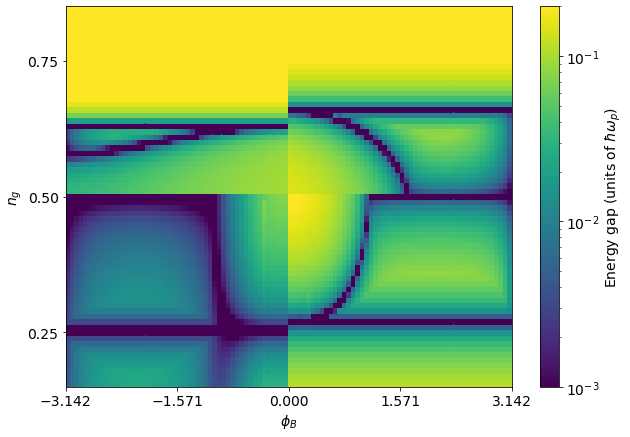

In [8]:
fig=plt.figure(figsize=(10,7))
plt.title('')

plt.rcParams.update({'font.size': 14})

X,Y = np.meshgrid(phiBlist_,nglist_,indexing='ij')  ### NEED indexing='ij' SO THAT MESHGRID DOES NOT INVERT X AND Y

plt.pcolormesh(X,Y,deg_gap_cut[:,1:], shading='nearest', norm=colors.LogNorm(vmin=1e-3,vmax=0.2), cmap='viridis') 
plt.colorbar(label='Energy gap (units of $\hbar \omega_p$)')
plt.xlabel('$\phi_B$')
plt.ylabel('$n_g$')
plt.xticks(np.arange(-np.pi,1.5*np.pi,0.5*np.pi))
plt.yticks(np.arange(0.25,1,0.25))
plt.ylim(bottom=0.15,top=0.85)
plt.show()